<a href="https://colab.research.google.com/github/fzantalis/colab_collection/blob/master/%CE%A3%CE%A6%CE%97%CE%9C%CE%9C%CE%A5_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

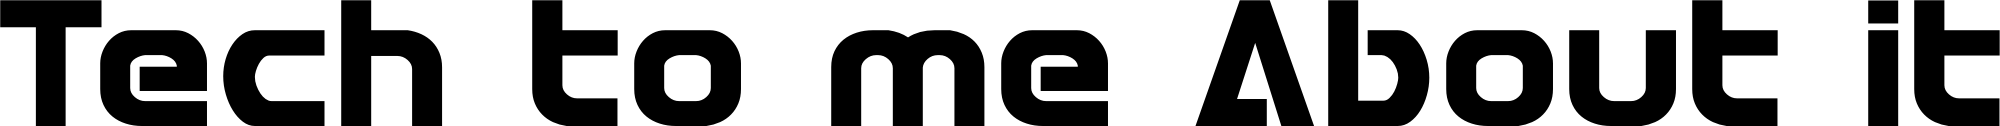


---


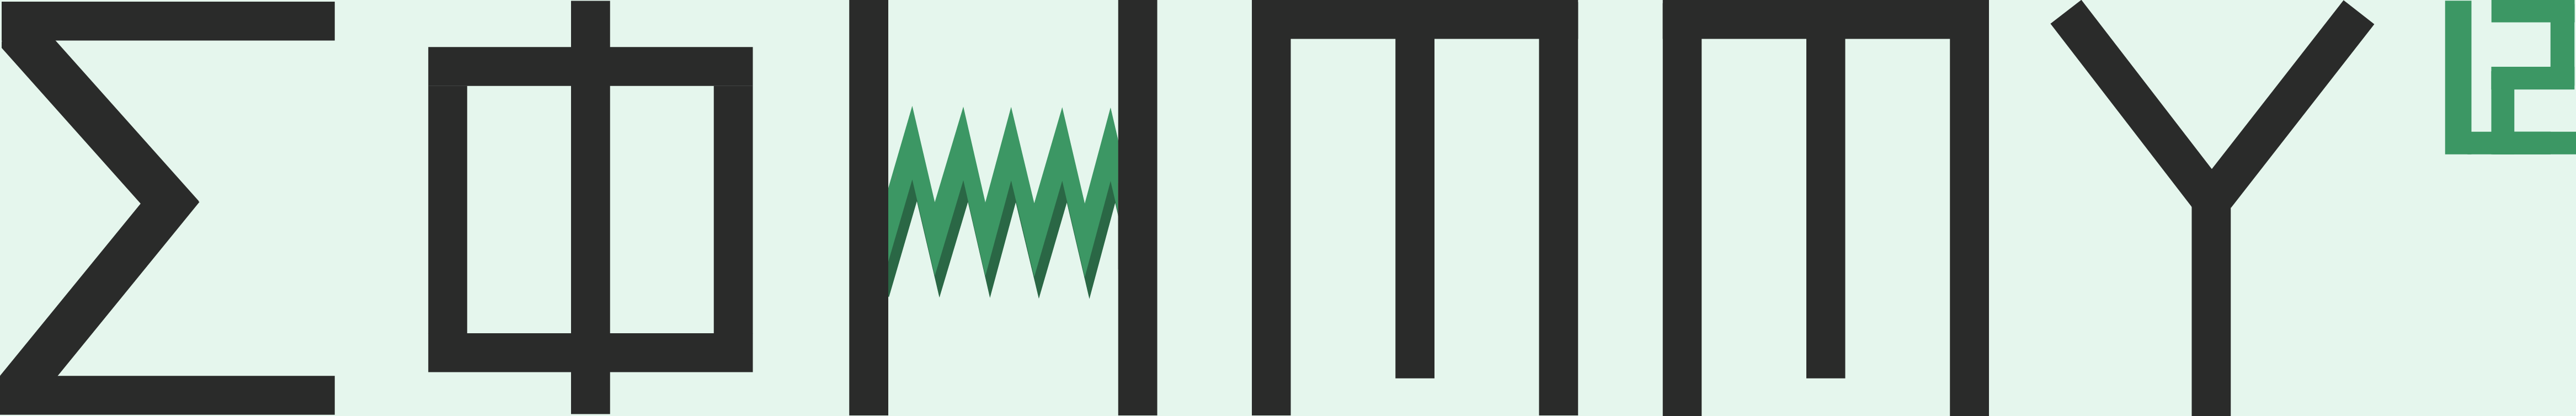

#Aυτό είναι ένα Jupyter Notebook που δημιουργήθηκε στα πλαίσια του ΣΦΗΜΜΥ 12.
##Σκοπός είναι η εξοικείωση με το εργαλείο μηχανικής μάθησης "Teachable Machine", καθώς και η χρήση του με εφευρετικούς τρόπους σε διάφορες εφαρμογές.

---

##Στο παρόν notebook υλοποιούνται 2 εφαρμογές χρησιμοποιώντας ένα προεκπαιδευμένο μοντέλο από το εργαλείο Teachable Machine.
###Πριν συνεχίσετε στις εφαρμογές θα πρέπει να εκπαιδευτεί ένα μοντέλο στην σελίδα: https://teachablemachine.withgoogle.com/

1.   Η πρώτη εφαρμογή είναι ένα έξυπνο quiz γνώσεων με θέμα το ελληνικό δακτυλικό αλφάβητο.
2.   Η δεύτερη εφαρμογή είναι ένας κειμενογράφος που λαμβάνει σαν είσοδο εικόνες συμβόλων από την κάμερα του χρήστη και τις αποτυπώνει σε γράμματα του ελληνικού αλφαβήτου.



#Εφαρμογή 1. Quiz Γνώσεων για την Εκμάθηση του Ελληνικού Δαχτυλικού Αλφάβητου

1. Δημιουργία ενός Python Dictionary που περιέχει τα ονόματα των κλάσεων του εκπαιδευμένου μοντέλου.

In [ ]:
# Generates a dict to store the labels(keys) and its names(values)
 
def gen_labels():
  labels = {}
  with open("labels.txt", "r") as label:
    text = label.read()
    lines = text.split("\n")
    for line in lines[0:-1]:
      hold = line.split(" ", 1)
      labels[hold[0]] = hold[1]
  return labels

2. Η παρακάτω συνάρτηση καλεί ένα κομμάτι Javascript μέσα από την Python, με σκοπό την ενεργοποίηση της κάμερας του χρήστη και την λήψη μίας εικόνας που θα χρησιμοποιηθεί για να τροφοδοτήσουμε το εκπαιδευμένο μοντέλο μας.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='frame.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality, seconds) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Υποβολή';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      
      //await new Promise(r => setTimeout(r, 10000));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

3. Η παρακάτω συνάρτηση λαμβάνει μία εικόνα σαν είσοδο και την δίνει σαν είσοδο στο εκπαιδευμένο μας μοντέλο, ώστε να γίνει η ταξινόμηση της στην κατάλληλη κλάση.

In [ ]:
import PIL.Image, PIL.ImageOps
import numpy as np

def detect_sign(model):
  
  labels = gen_labels()

  # Disable scientific notation for clarity
  np.set_printoptions(suppress=True)

  # Create the array of the right shape to feed into the keras model
  # The 'length' or number of images you can put into the array is
  # determined by the first position in the shape tuple, in this case 1.
  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

  # Replace this with the path to your image
  image = PIL.Image.open('frame.jpg')

  #resize the image to a 224x224 with the same strategy as in TM2:
  #resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = PIL.ImageOps.fit(image, size, PIL.Image.ANTIALIAS)

  #turn the image into a numpy array
  image_array = np.asarray(image)

  # display the resized image
  image.show()

  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

  # Load the image into the array
  data[0] = normalized_image_array

  # run the inference
  prediction = model.predict(data)
  sign = np.argmax(prediction)
  #print(prediction)
  #print(sign)
  return sign


In [ ]:
#@title Ρυθμίσεις του Quiz Εκμάθησης του Ελληνικού Δαχτυλικού Αλφάβητου

#@markdown Επιλέξτε τον επιθυμητό αριθμό των ερωτήσεων.

question_number = 5 #@param {type:"slider", min:1, max:5, step:1}

## Έναρξη!

In [ ]:
import random
import sys
import time
from IPython.display import Image, clear_output
import tensorflow.keras

labels = gen_labels()

# Load the model
model = tensorflow.keras.models.load_model('keras_model.h5', compile=False)

def countdown(t, msg):  
  for remaining in range(t, 0, -1):
    sys.stdout.write("\r")
    sys.stdout.write(msg + ": {:2d}".format(remaining))
    sys.stdout.flush()
    time.sleep(1)

 
letters_used = []
letter_num = 0
correct = 0
letters_used.append('_')
while letter_num < question_number:
  clear_output()
  letter = random.choice(list(labels.values()))
  if letter not in letters_used:
    letters_used.append(letter)
    letter_num += 1
    
    print("Ερώτηση " + str(letter_num) + ") Πως συμβολίζεται το γράμμα [" + letter + "];")

    try:
      filename = take_photo()
    
      print("Αναγνώριση συμβόλου...")
      sign = detect_sign(model)
      if labels[str(sign)] == letter:
        print("Σωστό!")
        correct += 1
      else:
        print('Λάθος. Το σύμβολο που έδειξες ταιριάζει περισσότερο στο γράμμα "' + labels[str(sign)] + '" αντί για το ζητούμενο γράμμα "' + letter + '"')
      if letter_num != (question_number):
        countdown(5, "Νέα ερώτηση σε")
      else: 
        time.sleep(5)

    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

clear_output()
print("Το quiz ολοκληρώθηκε!")
print("Βρήκες " + str(correct) + "/" + str(question_number) + " σωστά!")



---
#Εφαρμογή 2. Κειμενογράφος - Μεταγραφή Δαχτυλικού Αλφάβητου σε Κείμενο


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def writer(filename='frame.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality, seconds) {
      const div = document.createElement('div');
      //const capture = document.createElement('button');
      //capture.textContent = 'Υποβολή';
      //div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);
      await new Promise(r => setTimeout(r, 2500));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
#@title Ρυθμίσεις του κειμενογράφου
#@markdown Επιλέξτε τον επιθυμητό αριθμό γραμμάτων.

character_count = 6 #@param {type:"slider", min:1, max:100, step:1}

#Έναρξη

In [ ]:
import sys
import time
from IPython.display import Image, clear_output
import tensorflow.keras

labels = gen_labels()

# Load the model
model = tensorflow.keras.models.load_model('keras_model.h5', compile=False)

sentence = ""
sentence_length = 0
while sentence_length < character_count:
  clear_output()
  filename = writer()
  sign = detect_sign(model)
  print(labels[str(sign)])
  sentence += labels[str(sign)]
  sentence_length += 1
  time.sleep(1)

print(sentence)

